In [1]:
import numpy as np
import control as ct
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import animation, rc

In [2]:
#Intializations
Ts = 1E-2 #[s]
run_time = 30 #[s]

#Variables
g = 9.81 #gravity [m/s^2]
m = 1 #pendulum mass [kg]
l = 0.5 #pendulum length [m]
k_m = 0.5 #coeff static friction

#EKF Variables
var_Q = 1e-6 #process noise
var_R = 1e-6 #measurement noise
numb_sensor = 2 # TODO
Q1 = var_Q*np.eye(3) # TODO
Q2 = var_Q*np.eye(2) #TODO
P1 = var_R*np.eye(3) # TODO

R = var_R * np.eye(2*numb_sensor) # TODO
R2 = var_R * np.eye(2)  # TODO

#MFC EKF
"""
Add documentation about this guy 
"""
A_EKF = np.array([[1, Ts, 0.5*Ts**2],
                  [0, 1, Ts],
                  [0, 0, 1]])

beta = 1/(m*l**2) # From dynamics

B_EKF = np.array([[0.5*Ts**2*beta],
                  [Ts*beta],
                  [0]])
C_EKF = np.array([[1, 0, 0]])

set_point = np.pi/4
step_start = (10/Ts)

t = np.linspace(0,run_time,int(run_time/Ts))

states = np.zeros((3,3000))
outputs = np.zeros((3,3000))
u = np.zeros((1,3000))
u_mfc = np.zeros((1,3000))
true_F = np.zeros((1,3000))
int_value = 0

#Others???
prev_diff = np.zeros((1,3000))
x_hat = np.zeros((3,3000))
sigmaV = 0.0
P_hat = P1 #Why does he call it P1?

#Control Variables
e = np.zeros((1,3000))
e_dot = np.zeros((1,3000))
u_i = 0.0



In [3]:
#Pole Placement
def pole_placement():
    #State Space
    A = np.array([[0, 1, 0],\
              [0, 0, 0],\
              [1, 0, 0]])

    B = np.array([[0],\
              [1],\
              [0]])

    C = np.array([[1, 0]])  

    #Convergence Specs
    Mp = 0.10
    Ts = 1.0
    v = np.log(Mp)
    zeta = -v/np.sqrt(np.pi**2 + v**2)
    Wn = 4/(zeta*Ts)

    #Poles
    P2 = np.roots([1, 2*zeta*Wn, Wn**2])
    P = np.array([P2[0], P2[1], -10*np.real(P2[0])])

    K = ct.acker(A,B,P)
    K1 = K[0,0]
    K2 = K[0,1]
    K3 = K[0,2]

    return K1,K2,K3

In [4]:
#Reference Generation
def ref_gen(step_start, int_value, final_value):
    ref = np.ones((1,int(step_start)))*int_value
    tmp = np.size(ref)
    end_t = int(run_time/Ts)
    ref = np.append(ref, np.ones((1, end_t-tmp)) * final_value)
    return ref

In [5]:
def EKF(x1, x2, x3, u, P_Plus_k, Q, Ts, beta,k):

   f1 = lambda y1, y2, y3, t : y1+y2*t + 0.5*y3*(t**2) + 0.5*beta*(t**2)*u
   f2 = lambda y1, y2, y3, t : y2+y3*t + beta*t*u
   f3 = lambda y1, y2, y3, t: y3

   x_bar = np.zeros((3,1))

   #Only seperated into three variables for readability
   x_bar1 = f1(outputs[0,k],outputs[1,k],x_hat[2,k-1],Ts)
   x_bar2 = f2(outputs[0,k],outputs[1,k],x_hat[2,k-1],Ts)
   x_bar3 = np.array([f3(outputs[0,k],outputs[1,k],x_hat[2,k-1],Ts)])

   x_bar = np.array([x_bar1, x_bar2, x_bar3])

   
   #Step A: State Prediction
   A_hat = np.array([[1, Ts, 0.5*Ts**2],
               [0, 1, Ts],
               [0, 0, 1]])

   #Step B: Error Covariance Time Update
   P_minus_k = A_hat @ P_hat @ np.transpose(A_hat) + Q1

   #Step C: Output Prediction
   C_hat = np.array([[1, 0, 0],
                     [0, 1, 0]])
   
   D_hat = np.array(([0]))

   y_hat = C_hat @ x_bar

   # CORRECTION STEPS
   #Step D: Compute Kalman Gain Matrix
   #L[k] = P[k](-) * C(hat)' / (C(hat) * P[k](-) * C(hat)' + R
   ##Note: R is the measurement covariance matrix
   Lnum = P_minus_k @ np.transpose(C_hat) 
   #print(np.shape(Lnum))
   Lden = C_hat @ P_minus_k @ np.transpose(C_hat)
   #print(np.shape(Lden))
   L = np.linalg.lstsq(np.transpose(Lden),np.transpose(Lnum), rcond=None)
   #print(np.transpose(L[0]))

   #Step E: State Estimate Measurement Update
   y_true = np.array([x1, x2]).reshape((2,1))
   y_diff = (y_true - y_hat)
   x_plus_hat = x_bar + np.transpose(L[0]) @ y_diff
   #print(np.shape(x_plus_hat))

   #Step F: Error Covariance Measurement Update
   P_Plus_k = P_minus_k - np.transpose(L[0]) @ C_hat @ P_minus_k
   #print(np.shape(P_Plus_k))

   x1_hat = x_plus_hat[0,0]
   x2_hat = x_plus_hat[1,0]
   x3_hat = x_plus_hat[2,0]

   return (x1_hat, x2_hat, x3_hat, P_Plus_k, L)


In [6]:
ref = ref_gen(step_start, int_value, set_point)
ref=np.reshape(ref, ((1,3000)))

for k in range(1, np.size(t)):
    #print(k)

    #Non-Linear Dynamics
    """
    Takes in: outputs[:,k-1], u_mfc[:,k-1], ref[k]
    Returns: outputs[:,k], states[:,k]
    """
    states[0,k] = outputs[1,k-1] 
    states[1,k] = -(g/l)*np.sin(outputs[0,k-1]) -(k_m/m)*outputs[1,k-1] + (1/(m*l**2))*u_mfc[:,k-1]
    states[2,k] = ref[:,k] - outputs[0,k-1]
    outputs[:,k] = states[:,k] * Ts + outputs[:,k-1]

    #Error Calculations for the MF Controller States
    """ 
    Takes in: outputs[0,k], ref[k]
    """
    e[:,k] = ref[:,k] - outputs[0,k]
    e_dot[:,k] = (e[:,k] - e[:,k-1]) / Ts

    #Model Free Linear Controller (PID)
    K1,K2,K3 = pole_placement() ##NOTE: These match MATLAB perfectly
    u_i = u_i + e[:,k]*Ts
    u[:,k] = K2*e_dot[:,k] + K1*e[:,k] # + K3*u_i

    #Calculate the expected dynamics from the non-linear dynamics
    true_F[:,k] = -(g/l)*np.sin(outputs[0,k]) - (k/m)*outputs[1,k]

    #EKF 
    (x_hat[0,k], x_hat[1,k], x_hat[2,k], P_hat[:,:], L) =  EKF(outputs[0,k], outputs[1,k], x_hat[2,k-1], u_mfc[:,k-1], P_hat[:,:], Q1, Ts, beta,k)

    #Calculating the estimated dynamics (F)
    tmp = (ref[:,k] - ref[:,k-1]) / Ts
    tmp2 = (tmp - prev_diff[:,k]) / Ts
    prev_diff[:,k] = tmp

    
    u_mfc[:,k] = (tmp2 - u[:,k] - x_hat[2,k]) / beta





Text(0, 0.5, 'Angular Velocity (rad/s)')

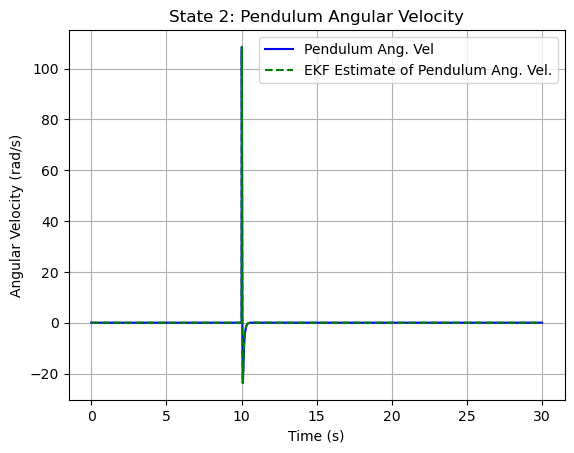

In [13]:
plt.grid(True)
plt.plot(t,outputs[1,:],'b',label="Pendulum Ang. Vel")
plt.plot(t,x_hat[1,:],'g--', label = "EKF Estimate of Pendulum Ang. Vel.")
plt.title('State 2: Pendulum Angular Velocity')
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Angular Velocity (rad/s)')

Text(0, 0.5, 'Angle (deg)')

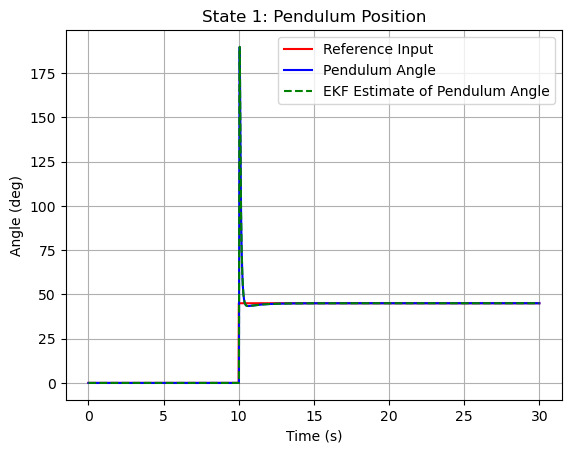

In [14]:
plt.plot(t,ref[0,:]*(180/np.pi), 'r', label="Reference Input")
plt.grid(True)
plt.plot(t,outputs[0,:]*(180/np.pi),'b',label="Pendulum Angle")
plt.plot(t,x_hat[0,:]*(180/np.pi),'g--', label = "EKF Estimate of Pendulum Angle")
plt.title('State 1: Pendulum Position')
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Angle (deg)')